In [3]:
import numpy as np
import astropy.io.fits as fitsio
import matplotlib.pyplot as plt 
from astropy.table import Table, vstack
import desimodel.io
import os
%matplotlib inline

# Functions to generate input files for fiberassign

In [70]:
def random_patch(n_dens=2500, plate_radius=1.61):
    """Generates a random set of points within a single plate.
    n_dens: number density of the random points to be generated
    plate_radius: radius of DESI plate in degrees.
    """
    n_total = int(4.0* n_dens * plate_radius**2)
    
    #The points are generated on a "square" centered around theta=pi/2 and phi=pi (spherical coordinates)
    phi = 2.0*(np.random.random(n_total) - 0.5) * np.deg2rad(plate_radius)
    costheta = 2.0*(np.random.random(n_total)-0.5) * np.deg2rad(plate_radius)
    theta = np.arccos(costheta) 
    
    #We now select the points inside the circle
    mu = np.cos(phi) * np.sin(theta) # dot product between each point and unit vector along x
    inside = np.abs(mu) > np.cos(np.deg2rad(plate_radius)) 
    return {'RA':np.rad2deg(np.pi - phi[inside]), 'DEC':np.rad2deg(theta[inside]-np.pi/2.0)}

def fill_columns(input_dict, priority=100):
    """Writes a tile file with a single tile.
    """
    column_vals = {'DESI_TARGET':1,
               'MWS_TARGET':0,
               'BGS_TARGET':0, 
               'OBSCONDITIONS':1, 
               'BRICKNAME':'180d000',
               'SUBPRIORITY':0,
               'NUMOBS_MORE':2,
               'PRIORITY':priority}
    
    n_points = len(input_dict['RA'])
    for k in column_vals.keys():
        if k not in input_dict.keys():
            if k=='SUBPRIORITY':
                input_dict[k] = np.random.random(n_points)
            else:
                input_dict[k] = np.repeat(column_vals[k], n_points)
    return input_dict

def write_targets(n_target_dens=100, n_sky_dens=2000, n_star_dens=120, only_write_mtl=False):
    """Generates mtl, sky and star files.
    """
    target_points = random_patch(n_dens=n_target_dens)
    sky_points = random_patch(n_dens=n_sky_dens)
    star_points = random_patch(n_dens=n_star_dens)

    n_target = len(target_points['RA'])
    n_sky = len(sky_points['RA'])
    n_star = len(star_points['RA'])
    n_tot = n_target +n_sky + n_star
    id_list = np.arange(n_tot)
    target_points['TARGETID'] = id_list[:n_target]
    sky_points['TARGETID'] = id_list[n_target:n_target+n_sky]
    star_points['TARGETID'] = id_list[-n_star:]

    target_points = fill_columns(target_points, priority=100)
    sky_points = fill_columns(sky_points, priority=10)
    star_points = fill_columns(star_points, priority=10)
    if only_write_mtl:
        Table(target_points).write('mtl.fits', overwrite=True)
    else:
        Table(target_points).write('mtl.fits', overwrite=True)
        Table(sky_points).write('sky.fits', overwrite=True)
        Table(star_points).write('star.fits', overwrite=True)
    return
    
def write_tile(ra=180.0, dec=0.0):
    tile = {'TILEID':[0], 
            'RA': [ra],
            'DEC': [dec],
            'PASS': [0],
            'IN_DESI': [1],
            'EBV_MED': [0.0],
            'AIRMASS': [1.0],
            'STAR_DENSITY': [1.0],
            'EXPOSEFAC': [1.0],
            'PROGRAM': ['DARK'],
            'OBSCONDITIONS': [1] }
    Table(tile).write('tile.fits', overwrite=True)
    return
def write_survey():
    """Write the list of tiles to be fiberassigned.
    """
    fx = open('surveytiles.txt', 'w')
    fx.write("0\n")
    fx.close()
    

def write_config(mtlfile="mtl.fits", 
                      stdfile="star.fits", 
                      skyfile="sky.fits", 
                      surveytiles="surveytiles.txt", 
                      outdir="./", 
                      tilefile="tile.fits", 
                      fibfile="./"):
    """Writes the configuration string for fiberassign.
    """
    config = " --mtl {mtlfile}  \
            --sky {skyfile}  \
            --stdstar {stdfile}  \
            --surveytiles {surveytiles}  \
            --footprint {tilefile}  \
            --positioners {fiberposfile} \
            --fibstatusfile {fiberstatusfile}  --outdir {outdir}"
  
    tx = config.format(
    mtlfile = mtlfile,
    stdfile = stdfile,
    skyfile = skyfile,
    surveytiles = surveytiles,
    outdir = outdir,
    tilefile = tilefile,
    fiberstatusfile = 'fiberstatus.ecsv',
    fiberposfile = desimodel.io.findfile('focalplane/fiberpos.txt'),
    )
    return tx

def run_fiberassign(fiberassign_exec='fiberassign'):
    config = write_config()
    os.system('rm -f tile_00000.fits')
    ll = '{} {}'.format(fiberassign_exec, config)
    #print(ll)
    os.system(ll)
    
def reset_subpriorities():
    t = Table.read('mtl.fits')
    n = len(t)
    t['SUBPRIORITIES'] = np.random.random(n)
    t.write('mtl.fits', overwrite='True')
    
def plot_assigned_available_unreachable(targets, obstargets, label='TARGETS'):
    plt.figure(figsize=(10,10))

    plt.subplot(221)
    plt.title('{} Assigned'.format(label))
    ii = np.in1d(targets['TARGETID'], obstargets['TARGETID'])
    id_assigned = targets['TARGETID'][ii]
    plt.scatter(targets['RA'][ii], targets['DEC'][ii], s=0.5)

    n_assigned = np.count_nonzero(ii)

    plt.subplot(222)
    #create a list of unique potential targets excluding the assigned ones.
    potunique = np.unique(pottargets['POTENTIALTARGETID'])
    jj = np.in1d(potunique, obstargets['TARGETID'], invert=True)
    potunique = potunique[jj]

    jj = np.in1d(targets['TARGETID'], potunique)
    id_available_not_assigned = targets['TARGETID'][jj]
    plt.scatter(targets['RA'][jj], targets['DEC'][jj], s =0.5)
    plt.title('{} Available but not assigned'.format(label))
    n_available_not_assigned = np.count_nonzero(jj)

    plt.subplot(223)
    kk = np.in1d(targets['TARGETID'], np.concatenate([id_assigned,id_available_not_assigned]), invert=True)
    it_never_available = targets['TARGETID'][kk]
    plt.scatter(targets['RA'][kk], targets['DEC'][kk], s=0.5)
    plt.title('{} Never available'.format(label))
    n_unavailable = np.count_nonzero(kk)

    print('Assigned {}: {}'.format(label, n_assigned))
    #print(n_assigned, n_available_not_assigned, n_unavailable, len(targets['TARGETID']))

    assert (n_assigned + n_available_not_assigned + n_unavailable)==len(targets['TARGETID'])
    
    #plot unassigned fibers
    fibers = desimodel.io.load_fiberpos()
    plt.subplot(224)
    ll = obstargets['TARGETID']==-1
    mm = np.in1d(fibers['FIBER'], obstargets['FIBER'][ll])
    plt.scatter(-fibers['X'][mm], -fibers['Y'][mm], s=0.5)
    plt.title('Unassigned Fibers')
    n_unassigned = np.count_nonzero(ll)
    print('Unassigned fibers {}'.format(n_unassigned))

# Master Branch. Extreme case #1: Low target density ($100$ deg$^{-2}$) . Sky density $2000$ deg$^{-2}$

In [71]:
write_targets(n_target_dens=100)
write_tile()
write_survey()
run_fiberassign(fiberassign_exec='fiberassign')
targets = Table.read('mtl.fits')
sky = Table.read('sky.fits')
star = Table.read('star.fits')
alltargets = vstack([targets, sky, star])
obstargets = Table.read('tile_00000.fits', hdu=1)
pottargets = Table.read('tile_00000.fits', hdu=2)

Assigned TARGETS: 661
Unassigned fibers 226
Assigned SKY: 4013
Unassigned fibers 226
Assigned STAR: 100
Unassigned fibers 226


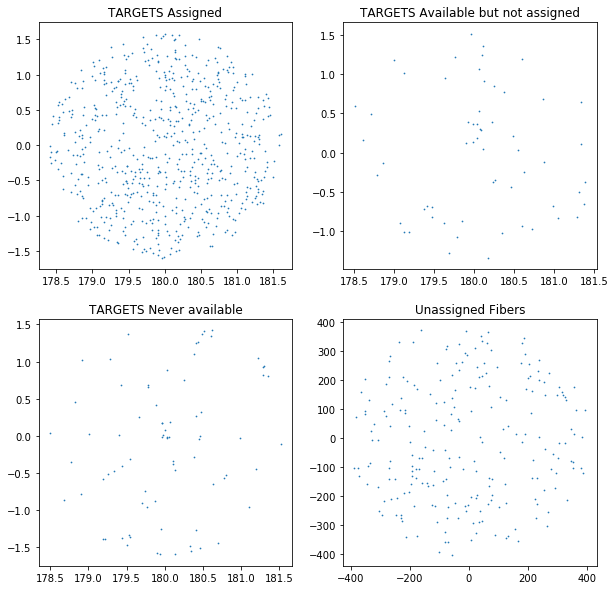

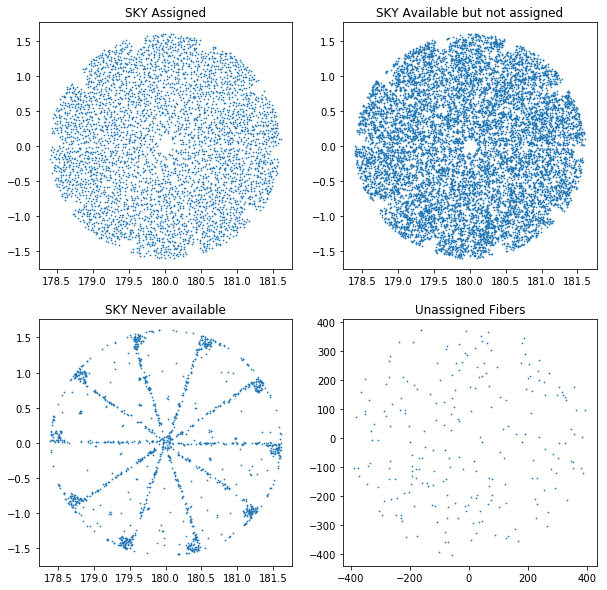

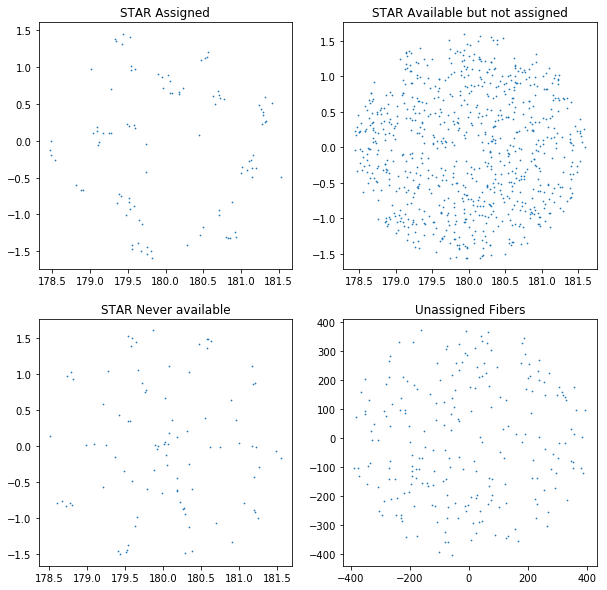

In [72]:
plot_assigned_available_unreachable(targets, obstargets)
plot_assigned_available_unreachable(sky, obstargets, label='SKY')
plot_assigned_available_unreachable(star, obstargets, label='STAR')

# Master Branch. Extreme case #2: High target density ($4000$ deg$^{-2}$) . Sky density $2000$ deg$^{-2}$

In [73]:
write_targets(n_target_dens=4000)
write_tile()
write_survey()
run_fiberassign(fiberassign_exec='fiberassign')
targets = Table.read('mtl.fits')
sky = Table.read('sky.fits')
star = Table.read('star.fits')
alltargets = vstack([targets, sky, star])
obstargets = Table.read('tile_00000.fits', hdu=1)
pottargets = Table.read('tile_00000.fits', hdu=2)

Assigned TARGETS: 4499
Unassigned fibers 1
Assigned SKY: 400
Unassigned fibers 1
Assigned STAR: 100
Unassigned fibers 1


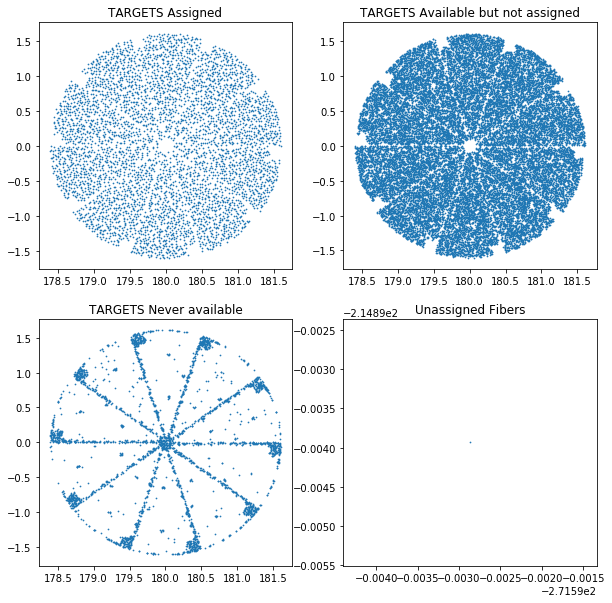

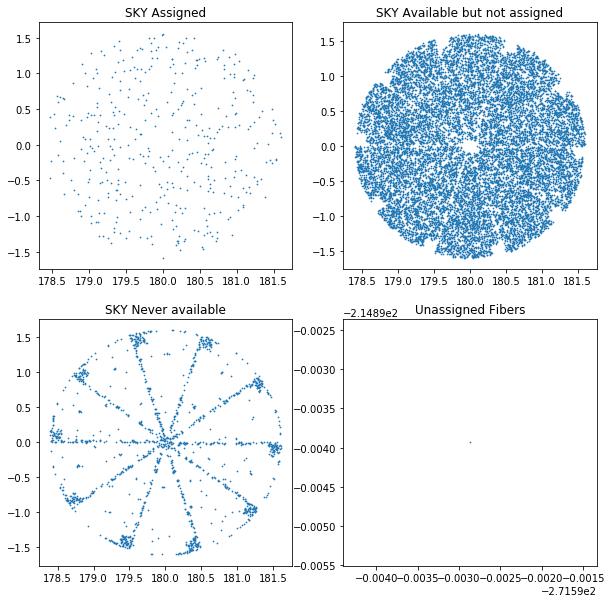

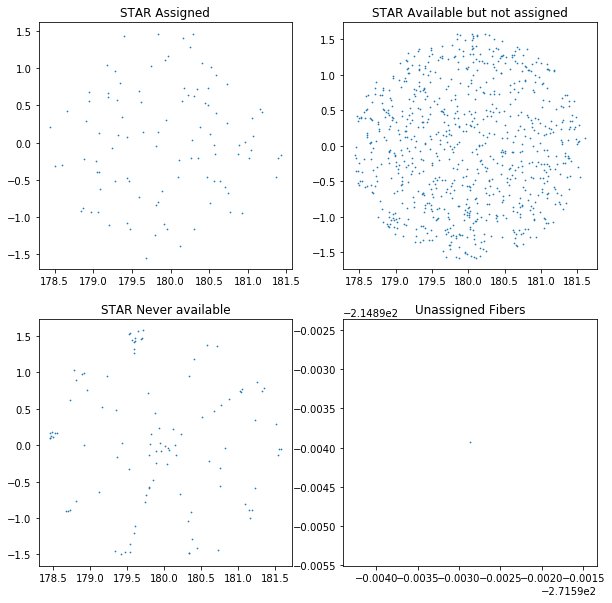

In [74]:
plot_assigned_available_unreachable(targets, obstargets)
plot_assigned_available_unreachable(sky, obstargets, label='SKY')
plot_assigned_available_unreachable(star, obstargets, label='STAR')

In [77]:
def count_sky_next_to_star(sky, stars, obstargets):
    ii = np.in1d(sky['TARGETID'], obstargets['TARGETID'])
    jj = np.in1d(obstargets['TARGETID'], sky['TARGETID'][ii])
    sky_fiber = obstargets['FIBER'][jj]
    
    ii = np.in1d(stars['TARGETID'], obstargets['TARGETID'])
    jj = np.in1d(obstargets['TARGETID'], stars['TARGETID'][ii])
    star_fiber = obstargets['FIBER'][jj]
    
    
    lined = 0
    for i in sky_fiber:
        if (i-1) in star_fiber :
            lined +=1
            #print('-', i, lined)
        if (i+1) in star_fiber:
            lined +=1
            #print('+', i, lined)
    return lined, len(sky_fiber), len(star_fiber)

In [87]:
n_run = 100
l = np.zeros(n_run)
n_sky = np.zeros(n_run)
n_star = np.zeros(n_run)
for i in range(n_run):
    print(i)
    write_targets(n_target_dens=4000)
    write_tile()
    write_survey()
    run_fiberassign(fiberassign_exec='fiberassign')
    targets = Table.read('mtl.fits')
    sky = Table.read('sky.fits')
    star = Table.read('star.fits')
    obstargets = Table.read('tile_00000.fits', hdu=1)
    l[i], n_sky[i], n_star[i] = count_sky_next_to_star(sky, stars, obstargets)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [88]:
l.mean(), l.std(), n_sky.mean(), n_star.mean()

(15.050000000000001,
 3.8350358538089315,
 400.04000000000002,
 91.890000000000001)

In [93]:
np.mean(l/n_star)

0.16390788185231286